In [2]:
import pandas as pd
import json
import numpy as np
import os
from tqdm import tqdm
import sys
import numpy as np
sys.path.append("/Users/yusufberkoruc/Desktop/Master_thesis/polnet")
from polnet.utils import *
from polnet import lio
from polnet import tem
from polnet import poly as pp
import shutil
import random
import time
from polnet.stomo import (
    SynthTomo,
    SetTomos,
)

In [3]:
def get_absolute_paths(parent_dir):
    """
    Get absolute paths of all directories inside a given directory.
    
    Parameters:
        parent_dir (str): Path to the parent directory.
    
    Returns:
        list: A list of absolute paths of subdirectories.
    """
    return [os.path.abspath(os.path.join(parent_dir, d)) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

def project_style_micrographs(style_tomo_dir, out_base_dir, tilt_range=(-60, 60, 3)):
    """
    Project style micrographs from reconstructed tomograms.

    Parameters:
        style_tomo_dir (str): Directory containing reconstructed tomograms (.mrc files).
        out_base_dir (str): Output base directory for the style micrographs.
        tilt_range (tuple): Range of tilt angles (start, stop, step).
    """
    os.makedirs(out_base_dir, exist_ok=True)
    style_tomo_files = [f for f in os.listdir(style_tomo_dir) if f.endswith('.mrc')]
    
    for i, filename in enumerate(sorted(style_tomo_files)):
        tomo_path = os.path.join(style_tomo_dir, filename)
        tomo_id = os.path.splitext(filename)[0]
        print(f"Processing style tomogram: {tomo_path}")

        # Load the reconstructed volume
        vol = lio.load_mrc(tomo_path)
        if vol is None or np.count_nonzero(vol) == 0:
            print(f"Skipping {filename}, empty or unreadable.")
            continue

        # Create output folder for projections
        tomo_output_dir = os.path.join(out_base_dir, f"StyleMicrographs_{tomo_id}")
        os.makedirs(tomo_output_dir, exist_ok=True)

        # Use TEM object to simulate tilt series (no noise, no misalignment)
        temic = tem.TEM(tomo_output_dir)
        temic.gen_tilt_series_imod(vol, np.arange(*tilt_range), ax="Y")

        # Save the style micrographs (no noise)
        style_mics_out = os.path.join(tomo_output_dir, f"{tomo_id}_style_mics.mrc")
        shutil.copyfile(temic._TEM__micgraphs_file, style_mics_out)
        print(f"Saved style projections to {style_mics_out}")

def copy_style_micrographs(source_dir, destination_dir):
    """
    Traverse the source directory, find style micrograph files, and copy them to the destination directory.

    Parameters:
        source_dir (str): The base directory containing the style micrographs.
        destination_dir (str): The directory where the selected files will be copied.
    """
    # Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)

    # Traverse the source directory
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Check if the file matches the pattern *_style_mics.mrc
            if file.endswith("_style_mics.mrc"):
                source_file_path = os.path.join(root, file)
                destination_file_path = os.path.join(destination_dir, file)

                # Copy the file to the destination directory
                shutil.copy2(source_file_path, destination_file_path)
                print(f"Copied: {source_file_path} → {destination_file_path}")



In [4]:
"""style_tomo_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/style_images"
out_base_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/style_micrographs"
project_style_micrographs(style_tomo_dir, out_base_dir)"""
# Example usage
"""source_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/style_images_output"
destination_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/copied_style_micrographs"
copy_style_micrographs(source_dir, destination_dir)"""

'source_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/style_images_output"\ndestination_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/copied_style_micrographs"\ncopy_style_micrographs(source_dir, destination_dir)'

In [5]:
def project_micrographs(out_base_dir, simulation_dirs, tilt_range=(-60, 60, 3), detector_snr=None, micrograph_threshold=100, reconstruct_3d=False):
    """
    Project micrographs from 3D densities and save all TEM-related files in the output directory.

    Parameters:
        out_base_dir (str): Directory to save the generated micrographs and TEM files.
        simulation_dirs (list): List of simulation directories containing 3D densities.
        tilt_range (tuple): Range of tilt angles (start, stop, step).
        detector_snr (list or float, optional): Signal-to-noise ratio for adding noise to micrographs.
        micrograph_threshold (int): Maximum number of micrographs to process.
        reconstruct_3d (bool): Whether to perform 3D reconstruction.
    """
    MALIGN_MN = 1
    MALIGN_MX = 1.5
    MALIGN_SG = 0.2
    simulation_index = 0
    micrograph_index = 0

    for sim_dir in sorted(simulation_dirs):
        if not os.path.exists(sim_dir):
            print(f"Simulation directory {sim_dir} does not exist. Skipping.")
            continue

        if not os.listdir(sim_dir):
            print(f"Simulation directory {sim_dir} is empty. Skipping.")
            continue

        print(f"Processing simulation directory: {sim_dir}")
        tom_dir = os.path.join(sim_dir, "tomos")
        if not os.path.exists(tom_dir):
            raise FileNotFoundError("Tomogram directory not found.")

        tomogram_files = [f for f in os.listdir(tom_dir) if f.startswith("tomo_den_") and f.endswith(".mrc")]
        n_tomos = len(tomogram_files)
        print(f"Found {n_tomos} tomograms to process in {tom_dir}.")

        for tomod_id in range(n_tomos):
            print("PROJECTING MICROGRAPHS FOR TOMOGRAM NUMBER:", tomod_id)
            hold_time = time.time()

            tomo_den_out = os.path.join(tom_dir, f"tomo_den_{tomod_id}.mrc")
            if not os.path.exists(tomo_den_out):
                raise FileNotFoundError(f"3D density file {tomo_den_out} is missing.")

            # Create a unique TEM directory for this tomogram
            tem_output_dir = os.path.join(out_base_dir, f"TEM/tomogram_{simulation_index}_{tomod_id}")
            os.makedirs(tem_output_dir, exist_ok=True)

            # Create output directory for micrographs
            tomo_output_dir = os.path.join(out_base_dir, f"Micrographs/tomogram_{simulation_index}_{tomod_id}")
            os.makedirs(tomo_output_dir, exist_ok=True)

            # Create a new TEM object for this tomogram
            temic = tem.TEM(tem_output_dir)
            vol = lio.load_mrc(tomo_den_out)
            if vol is None:
                raise ValueError(f"Failed to load 3D density file {tomo_den_out}.")
            if np.count_nonzero(vol) == 0:
                print(f"3D density file {tomo_den_out} is empty. Skipping.")
                continue

            temic.gen_tilt_series_imod(vol, np.arange(*tilt_range), ax="Y")

            clean_mics_path = os.path.join(tomo_output_dir, f"tomo_mics_clean_{tomod_id}.mrc")
            shutil.copyfile(temic._TEM__micgraphs_file, clean_mics_path)
            print(f"Saved clean noiseless projections to {clean_mics_path}")

            temic.add_mics_misalignment(MALIGN_MN, MALIGN_MX, MALIGN_SG)

            if detector_snr:
                snr = round(random.uniform(detector_snr[0], detector_snr[1]), 2) if isinstance(detector_snr, list) else detector_snr
                temic.add_detector_noise(snr)
                print(f"Added detector noise with SNR: {snr}")
            else:
                print("No detector noise added.")

            temic.invert_mics_den()
            out_mics = os.path.join(tomo_output_dir, f"tomo_mics_{tomod_id}_{snr}.mrc")
            shutil.copyfile(os.path.join(tem_output_dir, "out_micrographs.mrc"), out_mics)
            if reconstruct_3d:
                temic.recon3D_imod()
                temic.set_header(data="rec3d", p_size=(10, 10, 10), origin=(0, 0, 0))
            print(f"Micrographs for tomogram {tomod_id} projected in {time.time() - hold_time:.2f} seconds.")
            micrograph_index += 1
            print(f"Micrograph {micrograph_index} saved to {out_mics}.")
            if micrograph_index >= micrograph_threshold:
                print(f"Micrograph index {micrograph_index} exceeds threshold. Stopping further processing.")
                break
        simulation_index += 1
        print(f"Simulation {simulation_index} processed.")

    print("Successfully projected micrographs for all simulations.")

In [6]:
# Define the input directory containing simulation directories
input_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1"
simulation_dirs = get_absolute_paths(input_dir)
simulation_dirs = [d for d in simulation_dirs if not d.startswith(".")]
print(simulation_dirs)
# Define the output base directory
out_base_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2"

# Project micrographs and save all TEM files
project_micrographs(out_base_dir, simulation_dirs, tilt_range=(-60, 60, 3), detector_snr=[0.2, 0.3], micrograph_threshold=100, reconstruct_3d=False)

['/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii']
Processing simulation directory: /Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii
Found 30 tomograms to process in /Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii/tomos.
PROJECTING MICROGRAPHS FOR TOMOGRAM NUMBER: 0
Saved clean noiseless projections to /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_clean_0.mrc
Added detector noise with SNR: 0.24
Micrographs for tomogram 0 projected in 9.46 seconds.
Micrograph 1 saved to /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_0_0.24.mrc.
PROJECTING MICROGRAPHS FOR TOMOGRAM NUMBER: 1
Saved clean noiseless projections to /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_1/tomo_mics_clean_1.mrc
Added detector noise with SNR: 0.21
Micrographs for tomogram 1 projected in 9.23 second

In [2]:
import napari
import mrcfile
import numpy as np
import os

def visualize_micrographs(tomogram_paths):
    """
    Visualize reconstructed tomograms using Napari.

    Parameters:
        tomogram_paths (list): List of paths to the tomogram files (.mrc) to visualize.
    """
    viewer = napari.Viewer()

    for tomo_path in tomogram_paths:
        if not os.path.exists(tomo_path):
            print(f"File not found: {tomo_path}")
            continue

        # Load the tomogram
        with mrcfile.open(tomo_path, permissive=True) as mrc:
            tomo_data = np.copy(mrc.data)

        # Add the tomogram to the Napari viewer
        viewer.add_image(
            tomo_data,
            name=os.path.basename(tomo_path),
            colormap="gray",
            contrast_limits=(tomo_data.min(), tomo_data.max()),
        )
        print(f"Loaded tomogram: {tomo_path}")

    # Start the Napari event loop
    napari.run()

# Example usage
# Define the paths to the tomograms you want to visualize
tomo_paths = [
    "/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_0_0.24.mrc",
    "/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_clean_0.mrc",
]
# Call the function to visualize the tomograms
visualize_micrographs(tomo_paths)

Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_0_0.24.mrc
Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/Micrographs/tomogram_0_0/tomo_mics_clean_0.mrc


In [3]:
# Example usage
# Define the paths to the tomograms you want to visualize
tomo_paths = [
    "/Users/yusufberkoruc/Desktop/Master_thesis/style_micrographs/TS_5_4_style_mics.mrc",
    "/Users/yusufberkoruc/Desktop/Master_thesis/style_micrographs/TS_86_3_style_mics.mrc",
]
# Call the function to visualize the tomograms
visualize_micrographs(tomo_paths)

Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/style_micrographs/TS_5_4_style_mics.mrc
Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/style_micrographs/TS_86_3_style_mics.mrc


In [ ]:
def reconstruct_micrographs_only_recon3D(micrograph_paths,faket_paths, out_base_dir, custom_mic=False,micrograph_threshold=100):
    os.makedirs(out_base_dir, exist_ok=True)
    
    simulation_index = 0

    for micrograph_path,faket_path in zip(micrograph_paths,faket_paths):
        if not os.path.exists(micrograph_path):
            print(f"Micrograph file {micrograph_path} does not exist. Skipping.")
            continue

        print(f"Processing micrograph: {micrograph_path}")
        hold_time = time.time()

        tomo_output_dir = os.path.join(out_base_dir, f"Reconstructed_{simulation_index}")
        os.makedirs(tomo_output_dir, exist_ok=True)

        temic = tem.TEM(micrograph_path)
        temic.set_header(data="mics", p_size=(10, 10, 10))
        if custom_mic:
            custom_mic_file = faket_path
            if not os.path.exists(custom_mic_file):
                raise FileNotFoundError(f"Micrographs file {custom_mic_file} does not exist.")
            temic._TEM__micgraphs_file = custom_mic_file
        

        print("Micrographs file:", temic._TEM__micgraphs_file)
        print("Tilt file:", temic._TEM__tangs_file)
        print("Output file:", temic._TEM__rec3d_file)

        try:
            temic.recon3D_imod()
        except Exception as e:
            print(f"Error during reconstruction: {e}")
            continue
        if custom_mic:
            out_tomo_rec = os.path.join(tomo_output_dir, f"tomo_rec_faket_{simulation_index}_{snr}.mrc")
        else:
            out_tomo_rec = os.path.join(tomo_output_dir, f"tomo_rec_{simulation_index}_.mrc")
        if not os.path.exists(temic._TEM__rec3d_file):
            print(f"Reconstruction failed. Output file {temic._TEM__rec3d_file} not found.")
            continue

        shutil.copyfile(temic._TEM__rec3d_file, out_tomo_rec)
        print(f"Reconstructed tomogram saved to {out_tomo_rec}")
        print(f"Micrograph {simulation_index} processed in {time.time() - hold_time:.2f} seconds.")
        simulation_index += 1
        if simulation_index >= micrograph_threshold:
            # If the simulation index exceeds the threshold, stop further processing
            # and break out of the loop
            print(f"Simulation index {simulation_index} exceeds threshold. Stopping further processing.")
            break
    print("Reconstruction completed for all micrographs.")

In [ ]:
base_dir_micrographs = "/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM"
base_dir_faket = "/Users/yusufberkoruc/Desktop/Master_thesis/faket_mics_style_transfer_1"
out_base_dir="/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos"
micrograph_paths = sorted(get_absolute_paths(base_dir_micrographs), key=lambda x: int(x.split("_")[-1]))
print(micrograph_paths)
faket_paths = [os.path.join(base_dir_faket, f) for f in os.listdir(base_dir_faket) if f.endswith(".mrc")]
faket_paths = sorted(faket_paths, key=lambda x: int(x.split("_")[-1].split(".")[0]))
print(faket_paths)
reconstruct_micrographs_only_recon3D(micrograph_paths, faket_paths, out_base_dir, custom_mic=True,micrograph_threshold=100)
#reconstruct_micrographs_only_recon3D(micrograph_paths, faket_paths, out_base_dir, custom_mic=False,micrograph_threshold=100)

['/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_0', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_1', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_2', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_3', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_4', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_5', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_6', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_7', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_8', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_9', '/Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_10', '/Users/yusufberkoruc/Desktop/

Exception ignored in: <function MrcInterpreter.__del__ at 0x108f01620>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/polnet/lib/python3.13/site-packages/mrcfile/mrcinterpreter.py", line 146, in __del__
    self.close()
  File "/opt/anaconda3/envs/polnet/lib/python3.13/site-packages/mrcfile/mrcfile.py", line 166, in close
    super(MrcFile, self).close()
  File "/opt/anaconda3/envs/polnet/lib/python3.13/site-packages/mrcfile/mrcinterpreter.py", line 365, in close
    self.flush()
  File "/opt/anaconda3/envs/polnet/lib/python3.13/site-packages/mrcfile/mrcinterpreter.py", line 383, in flush
    self._iostream.write(np.ascontiguousarray(self.data))
KeyboardInterrupt: 


Reconstructed tomogram saved to /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_4/tomo_rec_faket_4.mrc
Micrograph 4 processed in 3.69 seconds.
Processing micrograph: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_5
Micrographs file: /Users/yusufberkoruc/Desktop/Master_thesis/faket_mics_style_transfer_1/tomo_style_transfer_5.mrc
Tilt file: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_5/out_tangs.tlt
Output file: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_5/out_rec3d.mrc
Reconstructed tomogram saved to /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_5/tomo_rec_faket_5.mrc
Micrograph 5 processed in 3.58 seconds.
Processing micrograph: /Users/yusufberkoruc/Desktop/Master_thesis/micrographs_output_dir_2/TEM/tomogram_0_6
Micrographs file: /Users/yusufberkoruc/Desktop/Master_thesis/faket_mics_style_transfer_1/tomo_style_tra

In [1]:
import mrcfile
import numpy as np
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import matplotlib.pyplot as plt

def compare_tomograms(tomo1_path, tomo2_path):
    """
    Compare two tomograms and calculate MSE and SSIM.

    Parameters:
        tomo1_path (str): Path to the first tomogram file (e.g., faket tomogram).
        tomo2_path (str): Path to the second tomogram file (e.g., basic tomogram).

    Returns:
        dict: A dictionary containing MSE, SSIM, and the difference array.
    """
    # Load the tomograms
    with mrcfile.open(tomo1_path, permissive=True) as mrc:
        tomo1 = np.copy(mrc.data)
    with mrcfile.open(tomo2_path, permissive=True) as mrc:
        tomo2 = np.copy(mrc.data)

    # Ensure the tomograms have the same shape
    if tomo1.shape != tomo2.shape:
        raise ValueError(f"Shape mismatch: {tomo1.shape} vs {tomo2.shape}")

    # Calculate MSE
    mse_val = mean_squared_error(tomo1, tomo2)

    # Calculate SSIM
    ssim_val = ssim(tomo1, tomo2, data_range=tomo2.max() - tomo2.min())

    # Calculate the difference
    difference = tomo1 - tomo2

    # Display the results
    print(f"MSE: {mse_val:.4f}")
    print(f"SSIM: {ssim_val:.4f}")

    # Visualize the difference
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Tomogram 1")
    plt.imshow(tomo1[tomo1.shape[0] // 2], cmap="gray")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Tomogram 2")
    plt.imshow(tomo2[tomo2.shape[0] // 2], cmap="gray")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Difference (Tomo1 - Tomo2)")
    plt.imshow(difference[tomo1.shape[0] // 2], cmap="seismic", vmin=-np.max(np.abs(difference)), vmax=np.max(np.abs(difference)))
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return {"MSE": mse_val, "SSIM": ssim_val, "Difference": difference}

MSE: 1.4593
SSIM: 0.0894


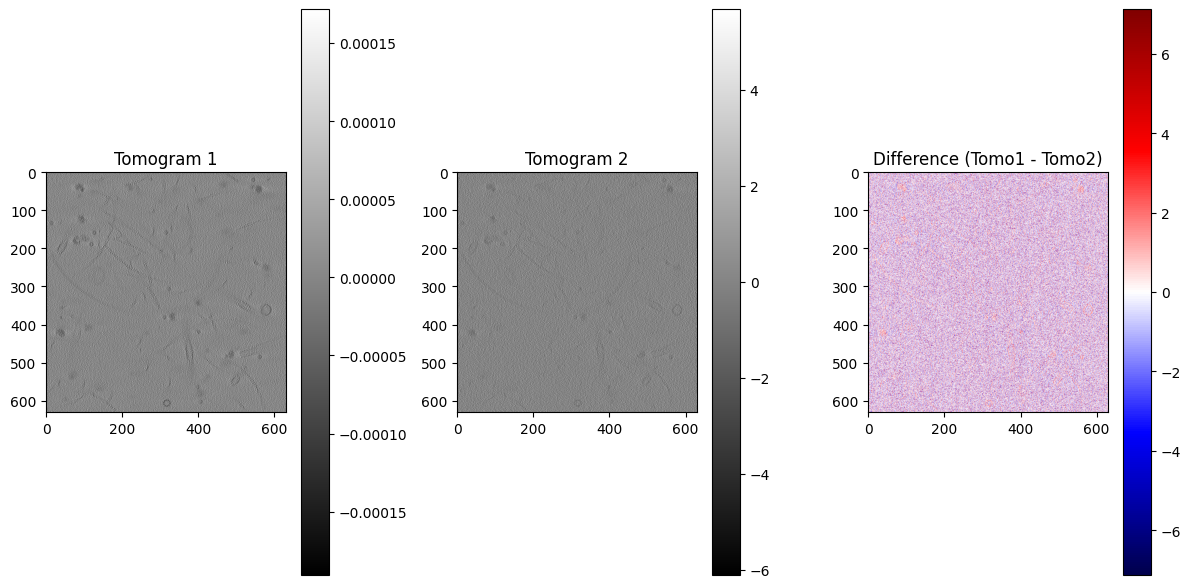

MSE: 1.4593
SSIM: 0.0894


In [9]:
faket_image_path = "/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_1/tomo_rec_faket_1.mrc"
basic_image_path = "/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_1/tomo_rec_1.mrc"

# Compare the tomograms
results = compare_tomograms(faket_image_path, basic_image_path)

# Print the results
print(f"MSE: {results['MSE']:.4f}")
print(f"SSIM: {results['SSIM']:.4f}")

In [ ]:
import napari
import mrcfile
import numpy as np
import os

def visualize_tomograms(tomogram_paths):
    """
    Visualize reconstructed tomograms using Napari.

    Parameters:
        tomogram_paths (list): List of paths to the tomogram files (.mrc) to visualize.
    """
    viewer = napari.Viewer()

    for tomo_path in tomogram_paths:
        if not os.path.exists(tomo_path):
            print(f"File not found: {tomo_path}")
            continue

        # Load the tomogram
        with mrcfile.open(tomo_path, permissive=True) as mrc:
            tomo_data = np.copy(mrc.data)

        # Add the tomogram to the Napari viewer
        viewer.add_image(
            tomo_data,
            name=os.path.basename(tomo_path),
            colormap="gray",
            contrast_limits=(tomo_data.min(), tomo_data.max()),
        )
        print(f"Loaded tomogram: {tomo_path}")

    # Start the Napari event loop
    napari.run()

"""# Example usage
if __name__ == "__main__":
    # Define paths to the reconstructed tomograms
    tomogram_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos"
    tomogram_paths = [
        os.path.join(tomogram_dir, "Reconstructed_0/tomo_rec_0.mrc"),
        os.path.join(tomogram_dir, "Reconstructed_0/tomo_rec_faket_0.mrc"),
        os.path.join(tomogram_dir, "Reconstructed_1/tomo_rec_faket_1.mrc"),
        os.path.join(tomogram_dir, "Reconstructed_1/tomo_rec_1.mrc"),
    ]

    # Visualize the tomograms
    visualize_tomograms(tomogram_paths)"""

Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_0/tomo_rec_0.mrc
Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_0/tomo_rec_faket_0.mrc
Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_1/tomo_rec_faket_1.mrc
Loaded tomogram: /Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_tomos/Reconstructed_1/tomo_rec_1.mrc


In [11]:
import os
import shutil
import random

def transform_directory_structure(source_dir, target_dir_faket, target_dir_basic):
    """
    Transform the directory structure to the desired format.

    Parameters:
        source_dir (str): Path to the source directory containing reconstructed tomograms.
        target_dir_faket (str): Path to the target directory for faket tomograms.
        target_dir_basic (str): Path to the target directory for basic tomograms.
    """
    # Ensure the target directories exist
    os.makedirs(target_dir_faket, exist_ok=True)
    os.makedirs(target_dir_basic, exist_ok=True)

    # Iterate through the source directory
    for folder in sorted(os.listdir(source_dir), key=lambda x: int(x.split('_')[-1])):
        folder_path = os.path.join(source_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        # Extract the tomogram index from the folder name
        tomogram_index = folder.split('_')[-1]

        # Process files in the folder
        for file in os.listdir(folder_path):
            source_file_path = os.path.join(folder_path, file)

            if file.endswith("_faket.mrc"):
                # Handle faket files
                new_folder_name = f"tomogram_0_{tomogram_index}"
                new_folder_path = os.path.join(target_dir_faket, new_folder_name)
                os.makedirs(new_folder_path, exist_ok=True)

                new_file_name = f"tomo_rec_faket_{tomogram_index}.mrc"
                new_file_path = os.path.join(new_folder_path, new_file_name)

                shutil.move(source_file_path, new_file_path)
                print(f"Moved (faket): {source_file_path} → {new_file_path}")

            elif file.endswith(".mrc") and not file.endswith("_faket.mrc"):
                # Handle basic files
                new_folder_name = f"tomogram_0_{tomogram_index}"
                new_folder_path = os.path.join(target_dir_basic, new_folder_name)
                os.makedirs(new_folder_path, exist_ok=True)

                new_file_name = f"tomo_rec_{tomogram_index}.mrc"
                new_file_path = os.path.join(new_folder_path, new_file_name)

                shutil.move(source_file_path, new_file_path)
                print(f"Moved (basic): {source_file_path} → {new_file_path}")

"""# Define the source directory
source_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_micrographs_1"

# Define the target directories for faket and basic tomograms
target_dir_faket = "/Users/yusufberkoruc/Desktop/Master_thesis/static_1/ExperimentRuns_faket"
target_dir_basic = "/Users/yusufberkoruc/Desktop/Master_thesis/static_1/ExperimentRuns_basic"

# Transform the directory structure
transform_directory_structure(source_dir, target_dir_faket, target_dir_basic)"""

'# Define the source directory\nsource_dir = "/Users/yusufberkoruc/Desktop/Master_thesis/reconstructed_micrographs_1"\n\n# Define the target directories for faket and basic tomograms\ntarget_dir_faket = "/Users/yusufberkoruc/Desktop/Master_thesis/static_1/ExperimentRuns_faket"\ntarget_dir_basic = "/Users/yusufberkoruc/Desktop/Master_thesis/static_1/ExperimentRuns_basic"\n\n# Transform the directory structure\ntransform_directory_structure(source_dir, target_dir_faket, target_dir_basic)'